In [1]:
import os
import pandas as pd
import numpy as np
import sys
import xarray as xr
from glmtools.io.glm import GLMDataset
import time

from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
data_folder = "./Data/"
sample_glm_file = data_folder + "GLM/240/00/OR_GLM-L2-LCFA_G17_s20202400000000_e20202400000200_c20202400000225.nc"

bbox = (-140, -30, 0, 60)

In [3]:
df = pd.read_csv(data_folder + "Laura/Hurricane_Laura_Trackfile_Spline.csv")

In [4]:
test = df[df["Date"] == "2020-08-20 00:00:00"]
test

,Unnamed: 0,Date,Long,Lat
468,468,2020-08-20 00:00:00,-46.980687,14.179562


In [5]:
test['Long'].values[0]

-46.98068713055332

In [6]:
def plot_groups(datafile, edges=(-180,180,-90,90),buffer=0):
    data = GLMDataset(datafile).dataset
    
    # time data in format "YYYY-MM-DD HH:MM:SS"
    time_str = data.time_coverage_start[:-3].replace('T', ' ')
    
    row = df[df["Date"] == time_str]
    if row.empty: # if time is not in trackfile
        return
    
    # extract data about groups
    groups = data[['group_energy','group_area']]
    groups = groups.drop(['group_parent_flash_id','lightning_wavelength','product_time','group_time_threshold','flash_time_threshold','lat_field_of_view','lon_field_of_view'])
    
    # draw the figure
    fig = plt.figure(dpi=200)
    map = Basemap(projection='merc', llcrnrlon=edges[0]-buffer, llcrnrlat=edges[2]-buffer,  # lower-left longitude and lattitude
                urcrnrlon=edges[1]+buffer,urcrnrlat=edges[3]+buffer,   # upper-right longitude and lattitude
                lon_0=0,lat_0=0, resolution='l')

    map.drawcoastlines()
    map.drawcountries()
    map.fillcontinents(color = 'tan')
    map.drawmapboundary()
    
    # Plot groups as medium green dots
    group_x, group_y = map(groups['group_lon'], groups['group_lat'])
    map.plot(group_x, group_y, 'go', markersize=1)
    
    # Plot center of the storm
    storm_center_lon, storm_center_lat = map(row['Long'].values, row['Lat'].values)    
    map.plot(storm_center_lon, storm_center_lat, 'ro', markersize=2)
        
    # Put time 
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    plt.annotate(time_str, xy=(1, 1), xytext=(-76, -7.5),
                 xycoords='axes fraction', textcoords='offset points',
                 fontsize=7, bbox=props)

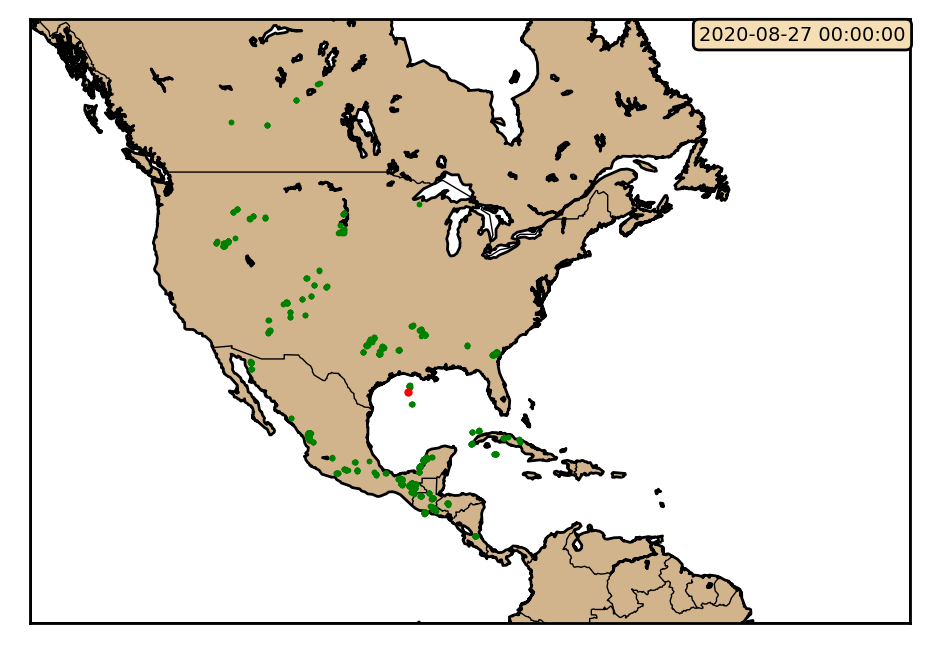

In [7]:
plot_groups(sample_glm_file, edges=bbox)
# +/-20 degree lat & lon
# 1500 km around storm center

In [8]:
def process_file(datafile, output_file, edges=(-180,180,-90,90),buffer=0):
    data = GLMDataset(datafile).dataset
    
    # time data in format "YYYY-MM-DD HH:MM:SS"
    time_str = data.time_coverage_start[:-3].replace('T', ' ')
    
    row = df[df["Date"] == time_str]
    if row.empty: # if time is not in trackfile
        return
    
    # extract data about groups
    groups = data[['group_energy','group_area']]
    groups = groups.drop(['group_parent_flash_id','lightning_wavelength','product_time','group_time_threshold','flash_time_threshold','lat_field_of_view','lon_field_of_view'])
    
    # draw the figure
    fig = plt.figure(dpi=200)
    map = Basemap(projection='merc', llcrnrlon=edges[0]-buffer, llcrnrlat=edges[2]-buffer,  # lower-left longitude and lattitude
                urcrnrlon=edges[1]+buffer,urcrnrlat=edges[3]+buffer,   # upper-right longitude and lattitude
                lon_0=0,lat_0=0, resolution='l')

    map.drawcoastlines()
    map.drawcountries()
    map.fillcontinents(color = 'tan')
    map.drawmapboundary()
    
    # Plot groups as medium green dots
    group_x, group_y = map(groups['group_lon'], groups['group_lat'])
    map.plot(group_x, group_y, 'go', markersize=1)
    
    # Plot center of the storm
    storm_center_lon, storm_center_lat = map(row['Long'].values, row['Lat'].values)    
    map.plot(storm_center_lon, storm_center_lat, 'ro', markersize=2)
        
    # Put time 
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    plt.annotate(time_str, xy=(1, 1), xytext=(-76, -7.5),
                 xycoords='axes fraction', textcoords='offset points',
                 fontsize=7, bbox=props)
    
    plt.savefig(output_file, bbox_inches='tight')
    plt.close()

In [9]:
process_file(sample_glm_file, "test.png", edges=bbox)

In [10]:
def process_hour(directory):
    i = 0;
    for f in tqdm(sorted(os.listdir(directory))):
        full_path = "{}/{}".format(directory, f)
#         print(full_path)
        process_file(full_path, "Images/{}_{:03d}.png".format(os.path.basename(directory),i), edges=bbox)
        i += 1

In [11]:
process_hour(data_folder + "GLM/239/00")

100%|██████████| 180/180 [00:35<00:00,  5.12it/s]


In [12]:
def process_day(directory):
    for i in range(24):
        process_hour("{}/{:02d}".format(directory, i))

In [13]:
process_day(data_folder + "GLM/240")

 23%|██▎       | 41/180 [00:09<00:31,  4.43it/s]


KeyboardInterrupt: 